# Chocolate Chip Cookies vs Raisin Cookies Image Classification

Our goal is to train a model that saves humanity from the repeated tragedy:

![cookies](https://github.com/cstorm125/choco-raisin/blob/main/images/choco_raisin_meme.jpg?raw=1)

We train a chocalate chip cookies vs raisin cookies image classifier with data obtained from [DuckDuckGo](http://duckduckgo.com/) image search. We obtained over 90% accruacy in the validation set. Train-validation split and label distribution are as follows:

```
- images
    - train
        -chocolate chip (572 images)
        - raisin (570 images)
    - valid
        -chocolate chip (144 images)
        - raisin (140 images)
```

## Installs and Imports

In [1]:
#install fastai2
!pip install -Uqq fastbook
import fastbook

     |████████████████████████████████| 727kB 6.5MB/s 
     |████████████████████████████████| 1.2MB 10.7MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 194kB 21.2MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 12.8MB 226kB/s 
     |████████████████████████████████| 776.8MB 22kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
#imports
from fastbook import *
from fastai.vision.widgets import *

import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from plotnine import *

import warnings
warnings.filterwarnings('ignore')

## Dataset from Repository

Get dataset from [cstorm125/choco-raisin](https://github.com/cstorm125/choco-raisin). Images are downloaded with `download_images.ipynb` and split with `train_valid_splits.ipynb`.

In [ ]:
#use this if you are running on colab
!npx degit github:cstorm125/choco-raisin#main choco-raisin
path = Path('choco-raisin/images')

# #use this instead if you are running on local
# path = Path('../images')

## From Data to DataLoaders

Construct dataloader from images. We decided to do squish resizing to prevent mistaken cropping of larger images (cropping part of the image where there are neither chocolate chips nor raisins).

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), #x - image; y - single class
    get_items=get_image_files, #get image
    splitter=GrandparentSplitter(), #use parent folder as train-valid split
    get_y=parent_label, #use parent folder as label
    #two choices for resizing and rationale
    #squishing to prevent cropping places without chips/raisins
    item_tfms=Resize(512, method=ResizeMethod.Squish), 
    # #cropping to preserve image quality; tried and doesn't work - peaked at 0.85 val acc
    # item_tfms=RandomResizedCrop(512),
    batch_tfms=aug_transforms(size=512), #standard fastai augmentation at size 512
    )
dls = dblock.dataloaders(path, bs=64) #batch size = 64

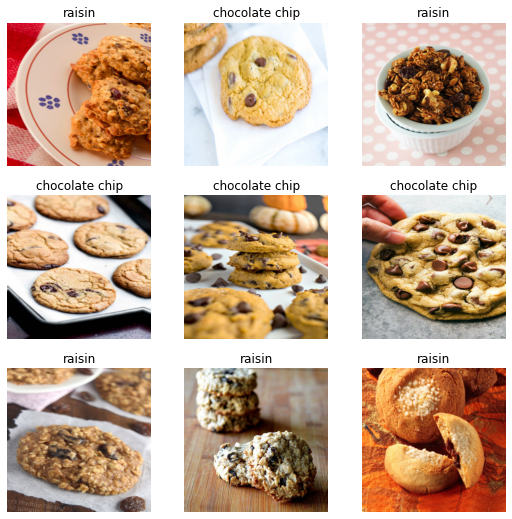

In [ ]:
dls.train.show_batch(max_n=9, nrows=3)

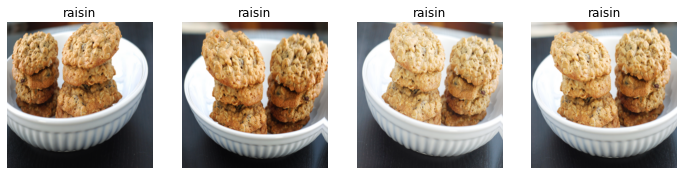

In [ ]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Train Model

We use `resnet34` to train the model with validation accuracy as the metric.

In [ ]:
learn = cnn_learner(dls, 
                    resnet34, 
                    metrics=[accuracy]).to_fp16()

We find that `1e-3` seems like a good base learning rate for 1cycle policy.

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.0005754399462603033)

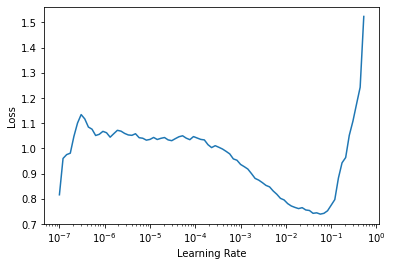

In [ ]:
learn.lr_find()

We train for 1 epoch with only the head layer and 5 epochs with all layers. Don't worry about `train_loss` being lower than `valid_loss`; as long as `valid_loss` (and `accuracy) continues to improve, we should keep training.

In [ ]:
learn.fine_tune(epochs=5,
          base_lr=1e-3, #base lr; when unfrozen base_lr/2
          freeze_epochs=1, #how many epochs to train frozen
          lr_mult=100, #train feature extractor with base_lr/lr_mult
          pct_start=0.2, #start decreasing lr at 
          div=5.0, #max lr = base_lr * div
          )

epoch,train_loss,valid_loss,accuracy,time
0,0.931468,0.610122,0.788732,00:55


epoch,train_loss,valid_loss,accuracy,time
0,0.504145,0.470962,0.802817,00:55
1,0.412538,0.394886,0.820423,00:56
2,0.341409,0.298652,0.883803,00:57
3,0.280804,0.260776,0.908451,00:57
4,0.237188,0.261246,0.901408,00:57


Train and validation losses.

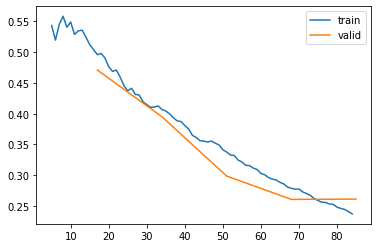

In [ ]:
learn.recorder.plot_loss()

Learning rate schedule, starting from base learning rate to max learning rate then gradually decreasing to zero.

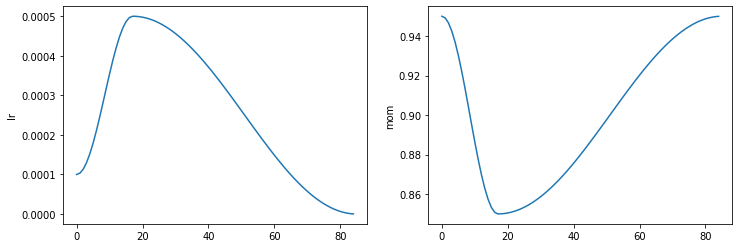

In [ ]:
learn.recorder.plot_sched()

Save the model for later uses.

In [ ]:
learn.save('resnet34_finetune1e3_5p');
learn.load('resnet34_finetune1e3_5p');

Create fastai interpretation object to check validation results.

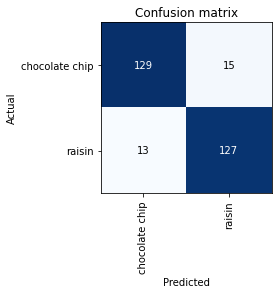

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Images with top losses, aka those that the model was most confident about but got it wrong.

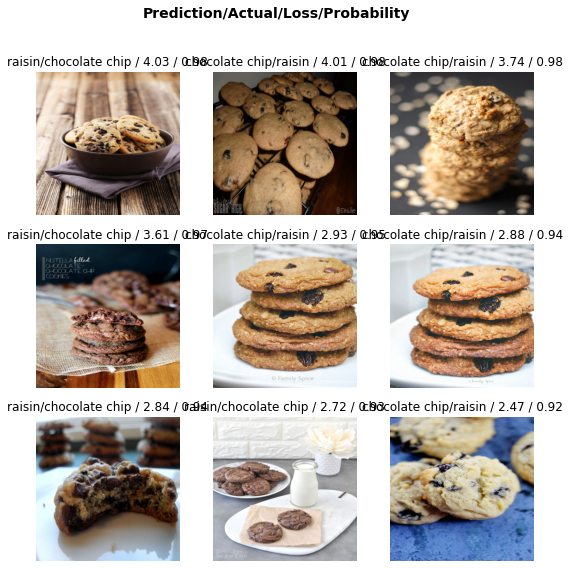

In [ ]:
interp.plot_top_losses(9, nrows=3)

Random batches of results in validation set (above - ground truth; below - prediction)

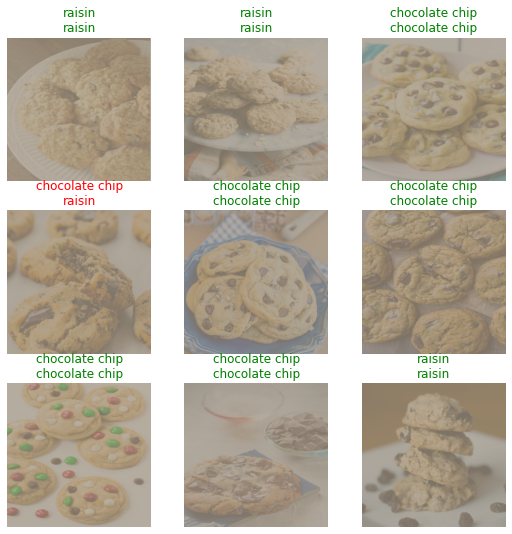

In [ ]:
learn.show_results()

## Threshold Optimization

Training a machine learning model is not only about blindly optimizing the loss function; we also need to think about the use case. In this case, if we were to deploy this model to check if we are fooled by a raisin cookies (or chocolate chip cookies if you like raisins more), then the threshold of predicting a class at 0.5 is unlikely to be optimal. 

In this case, cookies that we predict as chocolate chip should almost always be chocolate chip cookies. We are okay turning away some chocolate chip cookies (false negative) as long as our model does not predict raisin cookies as chocolate chip (false positive). In more technical terms, we want a high precision model thus our probability threshold is likely to be higher than 0.5.

Note that this is the opposite case compared to when we need a high recall model such as when we are creating a cancer detection model. We would rather say someone has cancer when they do not (and have them double-checked by human physicians) rather than letting someone who actually has cancer go home thinking they do not have cancer.

Always create a model with a purpose in mind.

In [ ]:
precision = Precision()
recall = Recall()
f1 = F1Score()

In [ ]:
probs, targs = learn.get_preds()

In [ ]:
#col 0 - choco
#col 1 - raisin
probs[-10:] 

tensor([[8.0571e-01, 1.9429e-01],
        [1.0000e+00, 3.2242e-08],
        [1.0000e+00, 4.2560e-06],
        [7.5702e-01, 2.4298e-01],
        [9.9546e-01, 4.5440e-03],
        [8.1931e-01, 1.8069e-01],
        [8.8489e-01, 1.1511e-01],
        [9.9962e-01, 3.8073e-04],
        [9.9968e-01, 3.2188e-04],
        [9.9971e-01, 2.8798e-04]])

In [ ]:
#0 - choco
#1 - raisin
targs[-10:]

TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

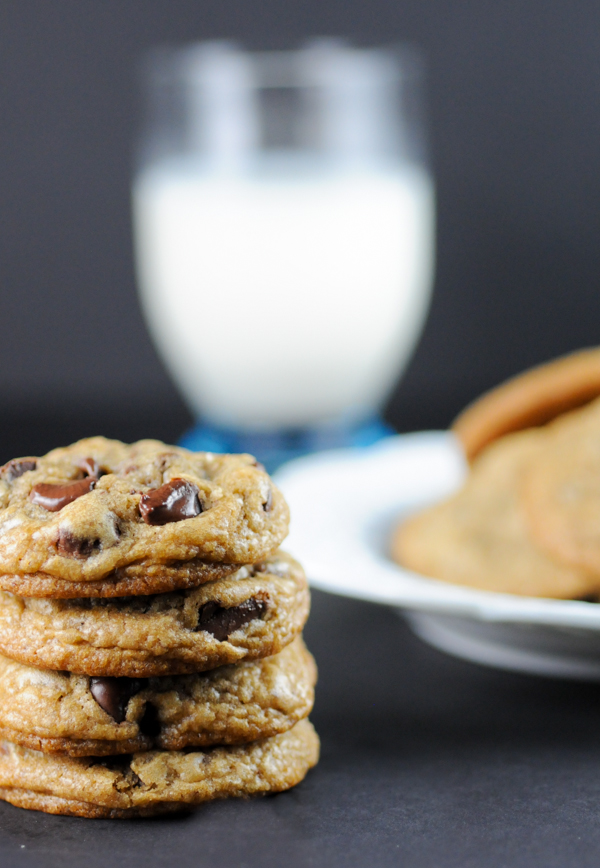

In [ ]:
dls.valid_ds[-10][0]

In [ ]:
is_choco = (targs-1).abs()
is_choco #1 if choco else 0

TensorCategory([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### High Precision Thresholds aka "When we say chocolate chip cookies, we want only chocolate chip cookies"

In [ ]:
def metric_finder(labels, probs, metric):
    thres = []
    metrics = []
    predicted_positives = []
    for i in tqdm(range(1,100)):
        thres.append(i/100)
        metrics.append(metric(probs>i/100,labels))
        predicted_positives.append((probs>i/100).sum().item() / labels.shape[0])
    return [list(a) for a in zip(thres,metrics,predicted_positives)]

df = pd.DataFrame(metric_finder(is_choco, probs[:,0],precision))
df.columns = ['threshold','precision','predicted_positive']
df #higher threshold, less images predicted as chocolate chip cookies, and high precision

,threshold,precision,predicted_positive
0,0.01,0.623377,0.813380
1,0.02,0.652968,0.771127
2,0.03,0.682692,0.732394
3,0.04,0.699507,0.714789
4,0.05,0.717172,0.697183
...,...,...,...
94,0.95,0.978495,0.327465
95,0.96,0.977528,0.313380
96,0.97,0.976471,0.299296
97,0.98,0.987805,0.288732


In [ ]:
df_m = df.melt(id_vars='threshold')
df_m

,threshold,variable,value
0,0.01,precision,0.623377
1,0.02,precision,0.652968
2,0.03,precision,0.682692
3,0.04,precision,0.699507
4,0.05,precision,0.717172
...,...,...,...
193,0.95,predicted_positive,0.327465
194,0.96,predicted_positive,0.313380
195,0.97,predicted_positive,0.299296
196,0.98,predicted_positive,0.288732


If we want 95% of what we predict as chocolate chip cookies to be so, we should probably set a threshold of around 0.8 where we will predict about 40% of the validation set as chocolate chip cookies.

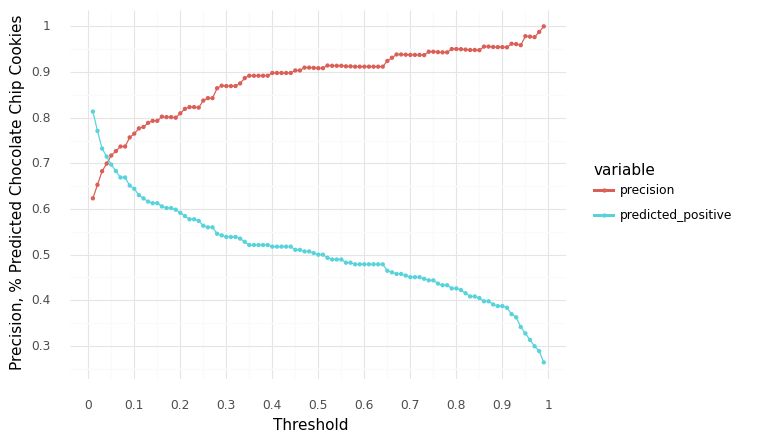

<ggplot: (8743098371833)>

In [ ]:
g = (ggplot(df_m, aes(x='threshold',y='value',group='variable',color='variable'))+ 
            geom_line() + geom_point(size=0.75) +
            ylab('Precision, % Predicted Chocolate Chip Cookies') +
            xlab('Threshold') +
            scale_x_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            scale_y_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            theme_minimal())
g

### High Recall Thesholds aka "When we say chocolate chip cookies, we want to get all the chocolate chip cookies, even though we get some raisin cookies mixed in too"

In [ ]:
def metric_finder(labels, probs, metric):
    thres = []
    metrics = []
    predicted_positives = []
    for i in tqdm(range(1,100)):
        thres.append(i/100)
        metrics.append(metric(probs>i/100,labels))
        predicted_positives.append((probs>i/100).sum().item() / labels.shape[0])
    return [list(a) for a in zip(thres,metrics,predicted_positives)]

df = pd.DataFrame(metric_finder(is_choco, probs[:,0],recall))
df.columns = ['threshold','recall','predicted_positive']
df #lower threshold, more images predicted as chocolate chip cookies, and high recall

,threshold,recall,predicted_positive
0,0.01,1.000000,0.813380
1,0.02,0.993056,0.771127
2,0.03,0.986111,0.732394
3,0.04,0.986111,0.714789
4,0.05,0.986111,0.697183
...,...,...,...
94,0.95,0.631944,0.327465
95,0.96,0.604167,0.313380
96,0.97,0.576389,0.299296
97,0.98,0.562500,0.288732


In [ ]:
df_m = df.melt(id_vars='threshold')
df_m

,threshold,variable,value
0,0.01,recall,1.000000
1,0.02,recall,0.993056
2,0.03,recall,0.986111
3,0.04,recall,0.986111
4,0.05,recall,0.986111
...,...,...,...
193,0.95,predicted_positive,0.327465
194,0.96,predicted_positive,0.313380
195,0.97,predicted_positive,0.299296
196,0.98,predicted_positive,0.288732


At 0.5 threshold, we already have recall of over 0.9 while predicting about 50% of the validation set as chocolate chip cookies.

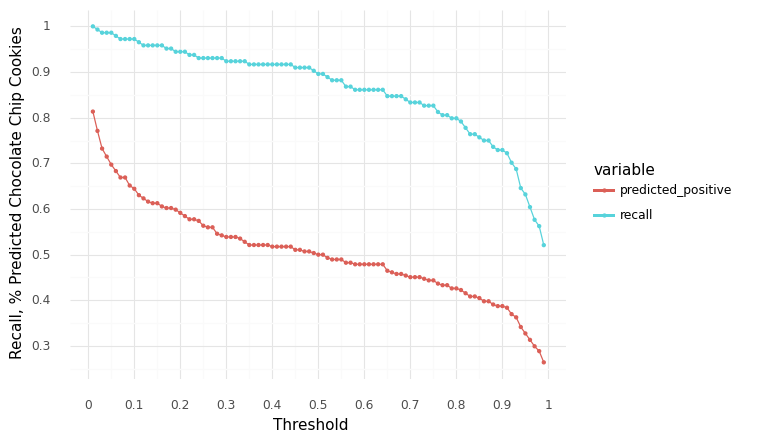

<ggplot: (8743098313237)>

In [ ]:
g = (ggplot(df_m, aes(x='threshold',y='value',group='variable',color='variable'))+ 
            geom_line() + geom_point(size=0.75) +
            ylab('Recall, % Predicted Chocolate Chip Cookies') +
            xlab('Threshold') +
            scale_x_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            scale_y_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            theme_minimal())
g

### Best of Both Worlds - High F1 Score

Technically a balance (harmonic mean) between precision and recall, but usually to difficult to interpret for real-life use cases and is more suited to model comparison.

In [ ]:
def metric_finder(labels, probs, metric):
    thres = []
    metrics = []
    predicted_positives = []
    for i in tqdm(range(1,100)):
        thres.append(i/100)
        metrics.append(metric(probs>i/100,labels))
        predicted_positives.append((probs>i/100).sum().item() / labels.shape[0])
    return [list(a) for a in zip(thres,metrics,predicted_positives)]

df = pd.DataFrame(metric_finder(is_choco, probs[:,0],f1))
df.columns = ['threshold','f1','predicted_positive']
df 

,threshold,f1,predicted_positive
0,0.01,0.768000,0.813380
1,0.02,0.787879,0.771127
2,0.03,0.806818,0.732394
3,0.04,0.818444,0.714789
4,0.05,0.830409,0.697183
...,...,...,...
94,0.95,0.767932,0.327465
95,0.96,0.746781,0.313380
96,0.97,0.724891,0.299296
97,0.98,0.716814,0.288732


In [ ]:
df_m = df.melt(id_vars='threshold')
df_m

,threshold,variable,value
0,0.01,f1,0.768000
1,0.02,f1,0.787879
2,0.03,f1,0.806818
3,0.04,f1,0.818444
4,0.05,f1,0.830409
...,...,...,...
193,0.95,predicted_positive,0.327465
194,0.96,predicted_positive,0.313380
195,0.97,predicted_positive,0.299296
196,0.98,predicted_positive,0.288732


It seems like, at 0.5, we are already at optimal threshold for F1 score.

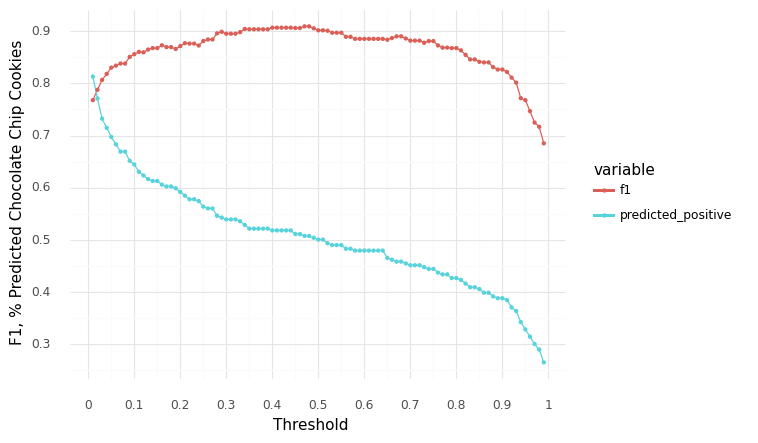

<ggplot: (8743098487645)>

In [ ]:
g = (ggplot(df_m, aes(x='threshold',y='value',group='variable',color='variable'))+ 
            geom_line() + geom_point(size=0.75) +
            ylab('F1, % Predicted Chocolate Chip Cookies') +
            xlab('Threshold') +
            scale_x_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            scale_y_continuous(breaks = [i/100 for i in range(0,101,10)]) +
            theme_minimal())
g

## Turning Your Model into an Online Application

### Using the Model for Inference

Export fastai `learner` for inference.

In [ ]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [ ]:
learn_inf = load_learner(path/'export.pkl')

In [ ]:
#predict a raisin image
learn_inf.predict('choco-raisin/images/valid/raisin/00000011.jpg')

('raisin', tensor(1), tensor([7.5490e-04, 9.9925e-01]))

In [ ]:
#predict a chocolate chip image
learn_inf.predict('choco-raisin/images/valid/chocolate chip/00000003.jpg')

('chocolate chip', tensor(0), tensor([9.9977e-01, 2.2962e-04]))

In [ ]:
learn_inf.dls.vocab

['chocolate chip', 'raisin']

### Creating a Notebook App from the Model

Run inference app in notebook.

In [ ]:
#upload button
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [ ]:
#image
img = PILImage.create(btn_upload.data[-1])

In [ ]:
#display as 128 * 128
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
#get prediction
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: chocolate chip; Probability: 1.0000')

### Putting Together a Notebook App

In [ ]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run = widgets.Button(description='Classify Cookies')
btn_run.on_click(on_click_classify)
btn_upload = widgets.FileUpload()

In [ ]:
VBox([widgets.Label('Select your cookies!'), 
      btn_upload, btn_run, out_pl, lbl_pred])